In [223]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import time
import importlib
plt.style.use('dark_background')

# import pdb

# Hyper Parameters
EPOCH = 100
BATCH_SIZE = 256
LR = 0.001         # learning rate
MNT = 0.9
WD = .0         # weight decay
DOWNLOAD_MNIST = False
N_TEST_IMG = 5
K = 50
m = 500
cudaopt = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='../data',
    train=True,                                     # this is training data
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize((0.1307,), (0.3081,)),
                             ]),    
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)


In [228]:
import models as mds
importlib.reload(mds)

model = mds.DictLearn(m).to(device)
    
# optimizer = torch.optim.Adam(model.parameters(), lr=LR)
optimizer = torch.optim.SGD(model.parameters(), lr=.5, momentum=.9)
loss_func = nn.MSELoss()


Before Training


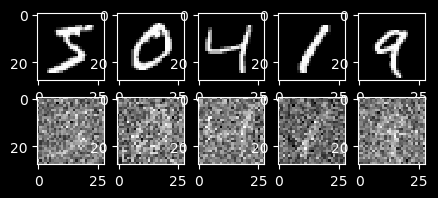

In [229]:
# initialize figure
print('Before Training')

fig = plt.figure(figsize=(5, 2))

# original data (first row) for viewing
view_data = train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.
view_data = view_data.to(device)
    
decoded_data,encoded_data, nnz = model(view_data,K)

for i in range(N_TEST_IMG):
    plt.subplot(2,N_TEST_IMG,i+1)
    plt.imshow(np.reshape(view_data.cpu().data.numpy()[i], (28, 28)), cmap='gray')

for i in range(N_TEST_IMG):
    plt.subplot(2,N_TEST_IMG,i+6)
    plt.imshow(np.reshape(decoded_data.cpu().data.numpy()[i], (28, 28)), cmap='gray')
    
plt.show()

In [230]:
# Training
Error = np.zeros((EPOCH,))
Loss = np.zeros((EPOCH,))
Ts = []
N = train_data.train_data.shape[0]
DISPLAY_FREQ = 1 ; 
TSHOW = np.round(DISPLAY_FREQ * N/BATCH_SIZE) # times per EPOCH to display information
t0 = time.perf_counter()
Ts = np.append(Ts,t0)
K = 25
DimK = 1

Err = []
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = (x.view(-1, 28*28)).to(device)   # batch x, shape (batch, 28*28)
        b_y = (x.view(-1, 28*28)).to(device)   # batch y, shape (batch, 28*28)
        b_label = (y).to(device)               # batch label

        decoded, encoded, errIHT = model(b_x,int(K))
        
        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
        
        Loss[epoch] = Loss[epoch] + loss.data[0]
        decoded = decoded.detach()
        err = np.linalg.norm( (decoded-b_x).cpu().numpy() ,'fro') / np.linalg.norm( b_x.cpu().numpy() ,'fro')
        Error[epoch] = Error[epoch] + errIHT[-1]
        Err = np.append(Err,errIHT[-1])
#         print(Error[epoch]/(step+1))
        
#         if step%50==0:
#             plt.plot(errIHT); plt.show()
    
    Loss[epoch] /= len(train_loader.dataset)
    Error[epoch] /= (step+1)
    print('Epoch: ', epoch, ', Error: ', Error[epoch], ', | train loss: %.4f' % Loss[epoch], ' NNZ: ', K )
    #K = max( Kmax - np.floor( (epoch+1)/DimK) ,Ktarget)
#     print('Finished Epoch: ', epoch, '| time ', np.round( 100*(Ts[-1] - Ts[-2]))/100 )


C:\Users\Jere\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch:  0 , Error:  0.456136647311 , | train loss: 0.0009  NNZ:  25
Epoch:  1 , Error:  0.377896960111 , | train loss: 0.0006  NNZ:  25
Epoch:  2 , Error:  0.361006196129 , | train loss: 0.0005  NNZ:  25
Epoch:  3 , Error:  0.348450139482 , | train loss: 0.0005  NNZ:  25
Epoch:  4 , Error:  0.33936467399 , | train loss: 0.0005  NNZ:  25
Epoch:  5 , Error:  0.332915499743 , | train loss: 0.0004  NNZ:  25
Epoch:  6 , Error:  0.328215509273 , | train loss: 0.0004  NNZ:  25
Epoch:  7 , Error:  0.324482657935 , | train loss: 0.0004  NNZ:  25
Epoch:  8 , Error:  0.321586027044 , | train loss: 0.0004  NNZ:  25
Epoch:  9 , Error:  0.319299975989 , | train loss: 0.0004  NNZ:  25
Epoch:  10 , Error:  0.317416117293 , | train loss: 0.0004  NNZ:  25
Epoch:  11 , Error:  0.315808172302 , | train loss: 0.0004  NNZ:  25
Epoch:  12 , Error:  0.314263990712 , | train loss: 0.0004  NNZ:  25
Epoch:  13 , Error:  0.312753686753 , | train loss: 0.0004  NNZ:  25
Epoch:  14 , Error:  0.310832825493 , | train

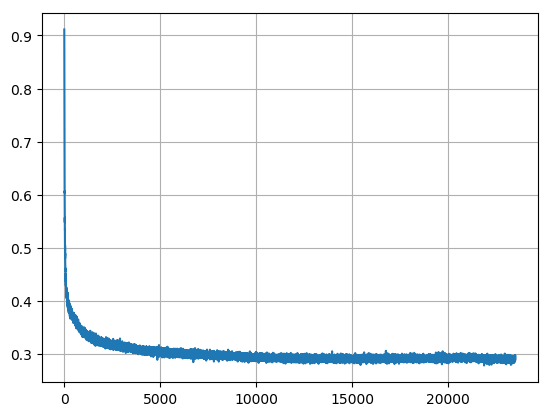

In [241]:
plt.style.use('default'); plt.plot(Err); plt.grid(); plt.show();

In [210]:
# Training
Error = np.zeros((EPOCH,))
Loss = np.zeros((EPOCH,))
Ts = []
N = train_data.train_data.shape[0]
DISPLAY_FREQ = 1 ; 
TSHOW = np.round(DISPLAY_FREQ * N/BATCH_SIZE) # times per EPOCH to display information
t0 = time.perf_counter()
Ts = np.append(Ts,t0)
Kmax = 100
Ktarget = 15
K = Kmax
DimK = 1

Err = []
for epoch in range(EPOCH):
    for step, (x, y) in enumerate(train_loader):
        b_x = (x.view(-1, 28*28)).to(device)   # batch x, shape (batch, 28*28)
        b_y = (x.view(-1, 28*28)).to(device)   # batch y, shape (batch, 28*28)
        b_label = (y).to(device)               # batch label

        decoded, encoded, errIHT = model(b_x,int(K))
        
        loss = loss_func(decoded, b_y)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients
        
        Loss[epoch] = Loss[epoch] + loss.data[0]
        decoded = decoded.detach()
        err = np.linalg.norm( (decoded-b_x).cpu().numpy() ,'fro') / np.linalg.norm( b_x.cpu().numpy() ,'fro')
        Error[epoch] = Error[epoch] + errIHT[-1]
        Err = np.append(Err,errIHT[-1])
#         print(Error[epoch]/(step+1))
        
#         if step%50==0:
#             plt.plot(errIHT); plt.show()
    
    Loss[epoch] /= len(train_loader.dataset)
    Error[epoch] /= (step+1)
    print('Epoch: ', epoch, ', Error: ', Error[epoch], ', | train loss: %.4f' % Loss[epoch], ' NNZ: ', K )
    # K = max( Kmax - np.floor( (epoch+1)/DimK) ,Ktarget)
#     print('Finished Epoch: ', epoch, '| time ', np.round( 100*(Ts[-1] - Ts[-2]))/100 )

C:\Users\Jere\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch:  0 , Error:  0.265823797853 , | train loss: 0.0006  NNZ:  100
Epoch:  1 , Error:  0.209111940187 , | train loss: 0.0003  NNZ:  99.0
Epoch:  2 , Error:  0.197777612504 , | train loss: 0.0003  NNZ:  98.0
Epoch:  3 , Error:  0.190376646007 , | train loss: 0.0003  NNZ:  97.0
Epoch:  4 , Error:  0.185064962138 , | train loss: 0.0003  NNZ:  96.0
Epoch:  5 , Error:  0.180678703796 , | train loss: 0.0003  NNZ:  95.0
Epoch:  6 , Error:  0.177392978245 , | train loss: 0.0002  NNZ:  94.0
Epoch:  7 , Error:  0.174707170361 , | train loss: 0.0002  NNZ:  93.0
Epoch:  8 , Error:  0.172385047716 , | train loss: 0.0002  NNZ:  92.0
Epoch:  9 , Error:  0.170432545674 , | train loss: 0.0002  NNZ:  91.0
Epoch:  10 , Error:  0.168725195152 , | train loss: 0.0002  NNZ:  90.0
Epoch:  11 , Error:  0.167283523057 , | train loss: 0.0002  NNZ:  89.0
Epoch:  12 , Error:  0.166045260582 , | train loss: 0.0002  NNZ:  88.0
Epoch:  13 , Error:  0.165105977292 , | train loss: 0.0002  NNZ:  87.0
Epoch:  14 , Erro

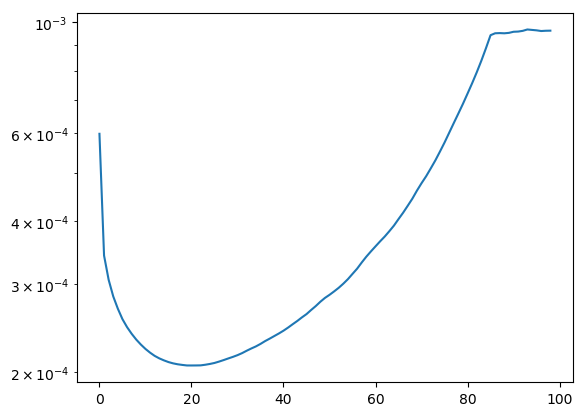

After Training


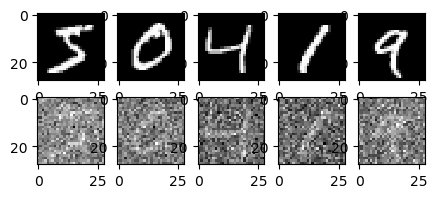

In [221]:
fig = plt.figure()
plt.style.use('default')
plt.semilogy(Loss[0:epoch])
plt.show()

print('After Training')
fig = plt.figure(figsize=(5, 2))
# original data (first row) for viewing
view_data = Variable(train_data.train_data[:N_TEST_IMG].view(-1, 28*28).type(torch.FloatTensor)/255.)
view_data = view_data.to(device)
decoded, encoded, nnz = model(view_data,int(25))

for i in range(N_TEST_IMG):
    plt.subplot(2,N_TEST_IMG,i+1)
    plt.imshow(np.reshape(view_data.cpu().data.numpy()[i], (28, 28)), cmap='gray')

for i in range(N_TEST_IMG):
    plt.subplot(2,N_TEST_IMG,i+6)
    plt.imshow(np.reshape(decoded.cpu().data.numpy()[i], (28, 28)), cmap='gray')
    
plt.show()

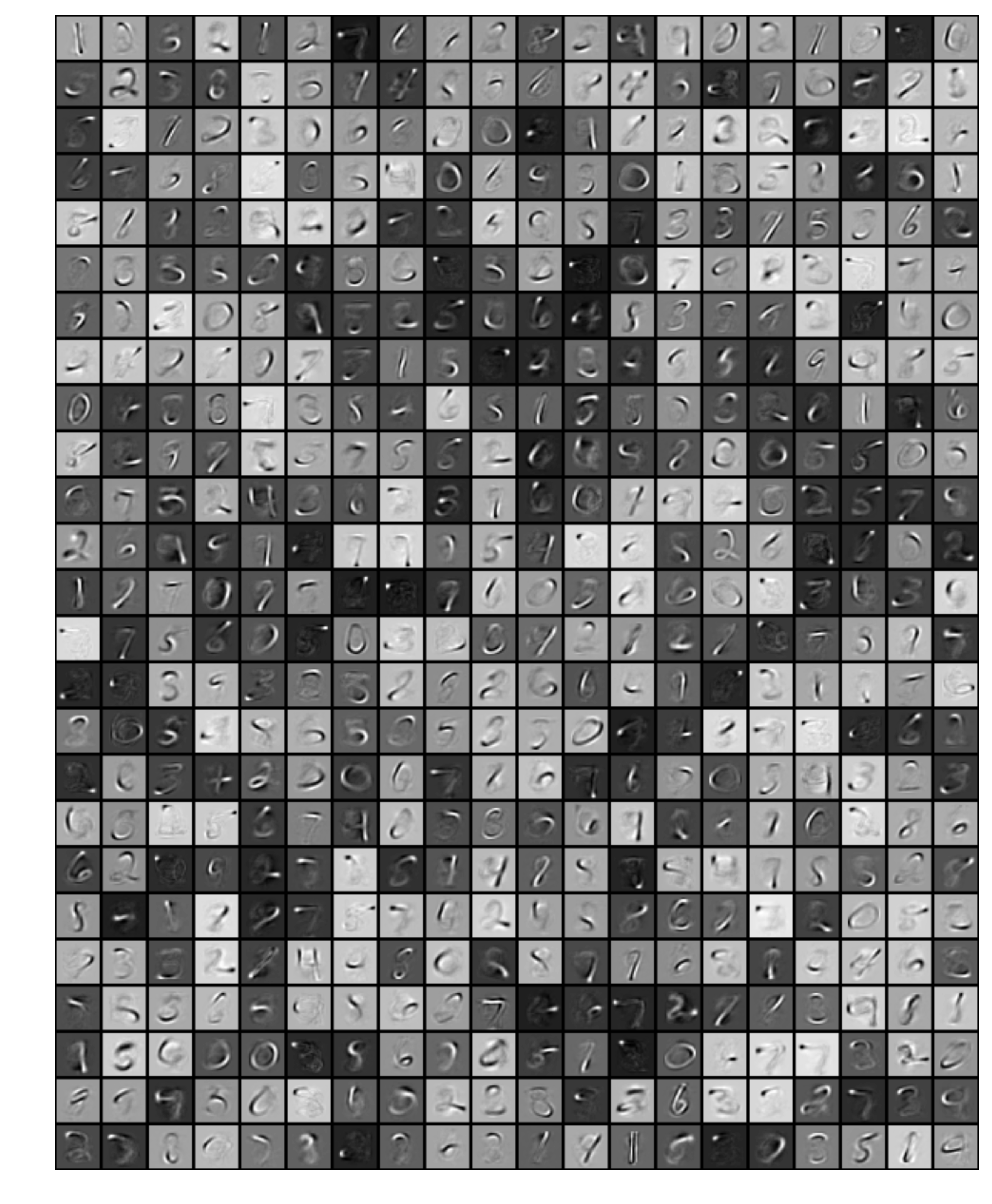

In [217]:
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

def showFilters(W,ncol,nrows):
    p = int(np.sqrt(W.shape[0]))+2
    Nimages = W.shape[1]
    Mosaic = np.zeros((p*ncol,p*nrows))
    indx = 0
    for i in range(ncol):
        for j in range(nrows):
            im = W[:,indx].reshape(p-2,p-2)
            im = (im-np.min(im))
            im = im/np.max(im)
            Mosaic[ i*p : (i+1)*p , j*p : (j+1)*p ] = np.pad(im,(1,1),mode='constant')
            indx += 1
            
    return Mosaic

W = model.cpu().W.data.numpy()

M1 = showFilters(W,25,20)
plt.figure(figsize=(15,15))
plt.imshow(rescale(M1,4,mode='constant'),cmap='gray')
plt.axis('off')
plt.show()

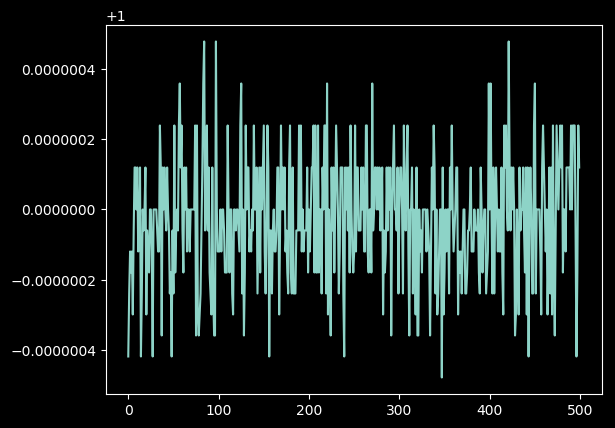

In [222]:
W = model.cpu().W.data.numpy()
Norms = np.sum(W**2,0)**0.5
plt.style.use('dark_background')
plt.plot(Norms)
plt.show()